In [1]:
import numpy as np
import pandas as pd
import timeit
import time
import matplotlib.pyplot as plt
import random
import scipy.io

In [2]:
import tensorflow.compat.v1 as tf
from tqdm import tqdm
import timeit 
tf.disable_v2_behavior()

2023-08-08 12:14:02.397707: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 12:14:02.399393: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 12:14:02.430172: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 12:14:02.430722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 12:14:03.170438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
dat1 =pd.read_csv('synthetic_Brusselator_data.csv')
dat1.head()

,# t,z1,z2
0,0.00000,1.000000,-1.000000
1,0.03003,0.904262,-0.902779
2,0.06006,0.824295,-0.818702
3,0.09009,0.756687,-0.744775
4,0.12012,0.698984,-0.678877


In [4]:
z1_data = np.array(dat1["z1"]).flatten()[:,None]
z2_data = np.array(dat1["z2"]).flatten()[:,None]
t_data = np.array(dat1["# t"]).flatten()[:,None]

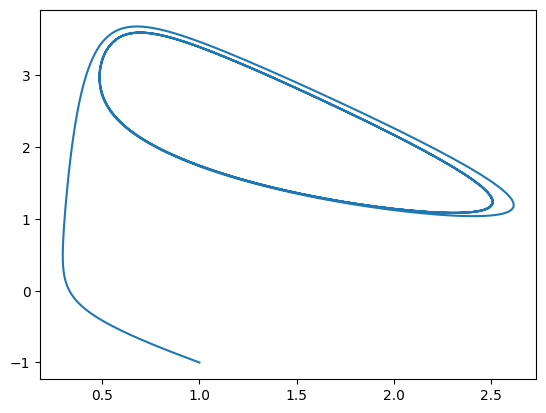

In [5]:
plt.plot(z1_data,z2_data,"-")
plt.show()

In [6]:
class PINN:
    # Initialize the class
    def __init__(self, t, z1, z2, layers, layers1, layers2):
        
        self.lb = t.min(0)
        self.ub = t.max(0)
        
        self.t = t
        
        self.z1 = z1
        self.z2 = z2
        
        self.layers = layers
        self.layers1 = layers1
        self.layers2 = layers2
        
        self.weights, self.biases = self.initialize_NN(layers)
        self.weights1, self.biases1 = self.initialize_NN(layers1)
        self.weights2, self.biases2 = self.initialize_NN(layers2)
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        

        
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.z1_tf = tf.placeholder(tf.float32, shape=[None, self.z1.shape[1]])
        self.z2_tf = tf.placeholder(tf.float32, shape=[None, self.z2.shape[1]])               
        
        self.z1_pred, self.z2_pred = self.net_ASIR(self.t_tf)
        self.aa_pred = self.aa_net(self.t_tf)
        self.bb_pred = self.bb_net(self.t_tf)
        
        self.l1, self.l2 = self.net_l(self.t_tf)
        
        self.loss = tf.reduce_sum(tf.square(self.z1_tf - self.z1_pred)) + \
                    tf.reduce_sum(tf.square(self.z2_tf - self.z2_pred)) + \
                    tf.reduce_sum(tf.square(self.l1)) + \
                    tf.reduce_sum(tf.square(self.l2))
        
        self.optimizer = tf.train.AdamOptimizer(1e-3)
        self.train_op = self.optimizer.minimize(self.loss)
        self.loss_log = []
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, t, layers, weights, biases):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def neural_net1(self, t, layers1, weights1, biases1):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights1[l]
            b = biases1[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights1[-1]
        b = biases1[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def neural_net2(self, t, layers2, weights2, biases2):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights2[l]
            b = biases2[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights2[-1]
        b = biases2[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    
    def net_ASIR(self, t):
        ASIR = self.neural_net(t, self.layers, self.weights, self.biases)
        z1 = ASIR[:,0:1]
        z2 = ASIR[:,1:2]
        
        return z1, z2
    
    def aa_net(self,t):
        aa = self.neural_net1(t, self.layers1, self.weights1, self.biases1)
        alp = aa
        return alp
    
    def bb_net(self,t):
        bb = self.neural_net2(t, self.layers2, self.weights2, self.biases2)
        blp = bb
        return blp
        
        
    def net_l(self, t):
        z1, z2 = self.net_ASIR(t)
        aa = self.aa_net(t)
        bb = self.bb_net(t)
        
        z1_t = tf.gradients(z1, t)[0]
        z2_t = tf.gradients(z2, t)[0]
        
        # l1 = z1_t - (1 - (bb + 1)*z1 + aa*(z1**2)*z2)
        # l2 = z2_t - (bb*z1 - aa*(z1**2)*z2) 
        
        l1 = z1_t - (aa + z1**2*z2 - (bb + 1)*z1)
        l2 = z2_t - (bb*z1 - z1**2*z2) 
        
        return l1, l2 
        
        
    def train(self, nIter):
        tf_dict = {self.t_tf: self.t, self.z1_tf: self.z1, self.z2_tf: self.z2}
        start_time = timeit.default_timer()

        for it in tqdm(range(nIter)):
            self.sess.run(self.train_op, tf_dict)
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.loss_log.append(loss_value)
                start_time = timeit.default_timer()
                
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        
        z1_star = self.sess.run(self.z1_pred, tf_dict)
        z2_star = self.sess.run(self.z2_pred, tf_dict)
        aa_star = self.sess.run(self.aa_pred, tf_dict)
        bb_star = self.sess.run(self.bb_pred, tf_dict)
        
        return z1_star, z2_star, aa_star, bb_star
        


In [7]:
niter = 50000  # number of Epochs
layers = [1, 64, 64, 64, 2]
layers1 = [1, 64, 64, 64, 1]
layers2 = [1, 64, 64, 64, 1]

model = PINN(t_data, z1_data, z2_data, layers, layers1, layers2)
model.train(niter)

Device mapping: no known devices.


2023-08-08 12:14:04.201869: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-08 12:14:04.787566: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-08-08 12:14:04.792879: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:14:04.792897: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-08 12:14:04.792901: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2

truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Var

100%|██████████| 50000/50000 [01:51<00:00, 450.04it/s]


In [8]:
# prediction
z1_pred, z2_pred, aa_pred, bb_pred = model.predict(t_data)

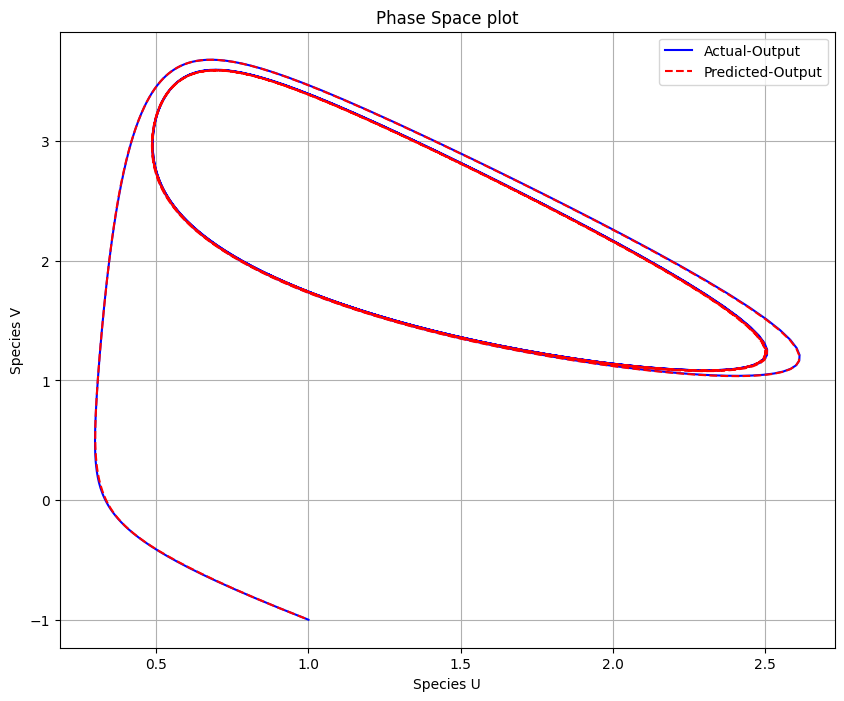

In [9]:
plt.rcParams['figure.figsize'] = [10,8]
plt.plot(z1_data,z2_data,'b')
plt.plot(z1_pred,z2_pred,'r--')
plt.legend(["Actual-Output", "Predicted-Output"])
plt.xlabel('Species U')
plt.ylabel("Species V")
plt.title("Phase Space plot")
plt.grid(True)
plt.show()

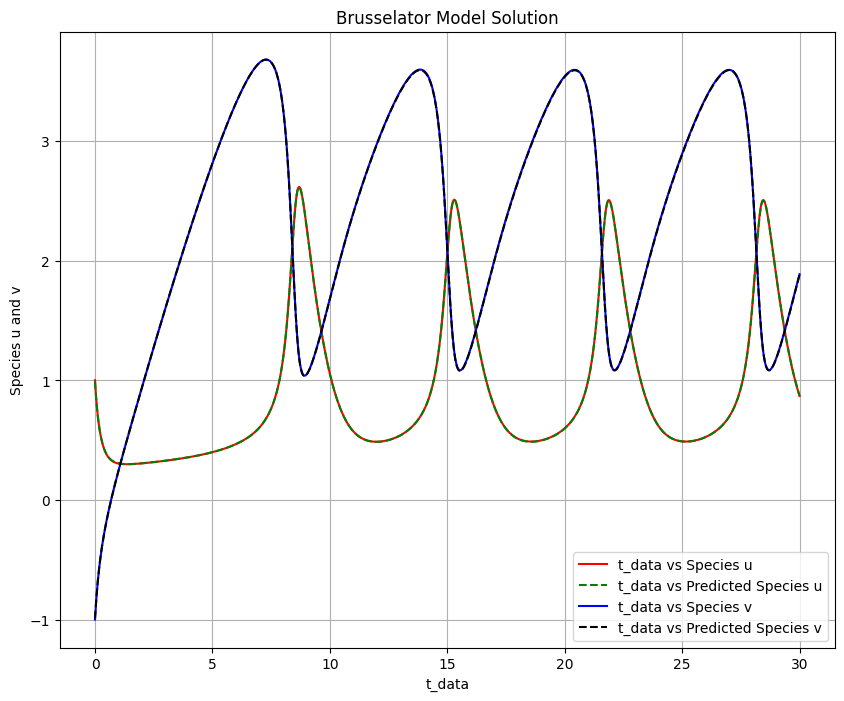

In [10]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_data,z1_data,'r')
#plt.plot(t_data,z1_data,'o')
plt.plot(t_data,z1_pred,'g--')

plt.plot(t_data,z2_data,'b')
#plt.plot(t_data,z2_data,'o')
plt.plot(t_data,z2_pred,'k--')

plt.xlabel('t_data')
plt.ylabel("Species u and v")
plt.grid(True)
plt.legend(["t_data vs Species u","t_data vs Predicted Species u", "t_data vs Species v",  "t_data vs Predicted Species v"])
plt.title("Brusselator Model Solution")
  
plt.show()

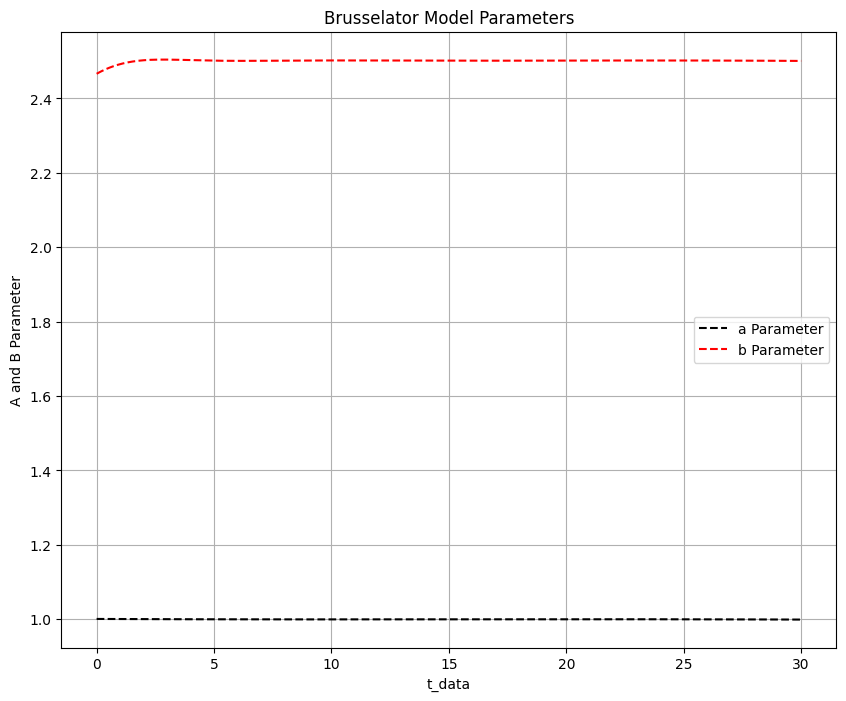

In [11]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_data,aa_pred,'k--')
plt.plot(t_data,bb_pred,'r--')

plt.xlabel('t_data')
plt.ylabel("A and B Parameter")
plt.legend(["a Parameter", "b Parameter"])
plt.title("Brusselator Model Parameters")
plt.grid(True)
plt.show()

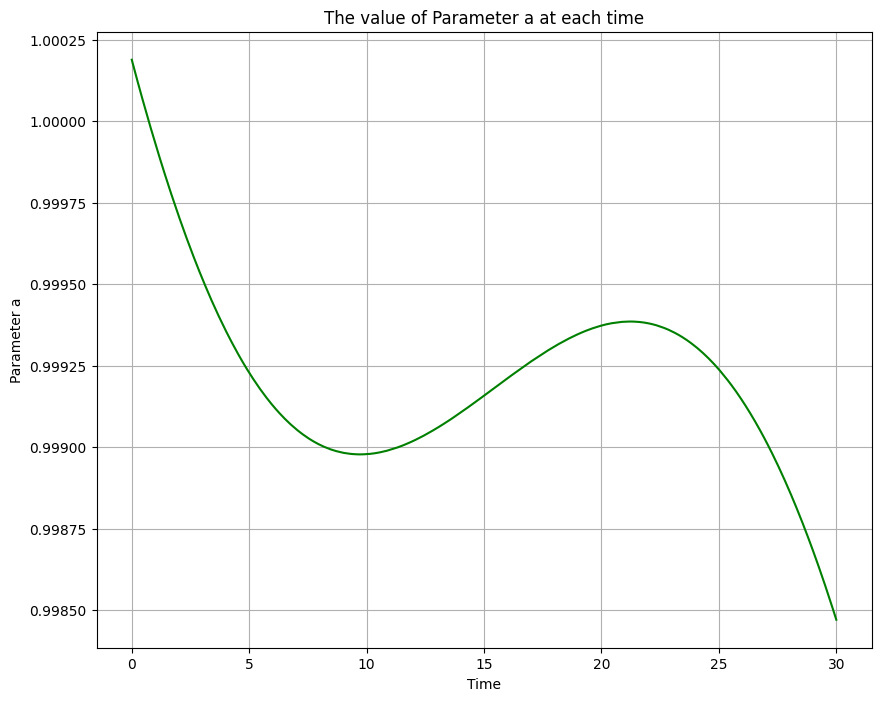

In [12]:
start_range = 0.0
end_range = 30.0

# Find the indices that correspond to the specified range
indices = [i for i, t in enumerate(t_data) if start_range <= t <= end_range]

# Extract the corresponding t_data and aa_pred values
t_data_filtered = [t_data[i] for i in indices]
aa_pred_filtered = [aa_pred[i] for i in indices]

# Plot the filtered data
plt.plot(t_data_filtered, aa_pred_filtered, "g")
plt.xlabel('Time')
plt.ylabel('Parameter a')
plt.grid(True)
plt.title('The value of Parameter a at each time')
plt.show()

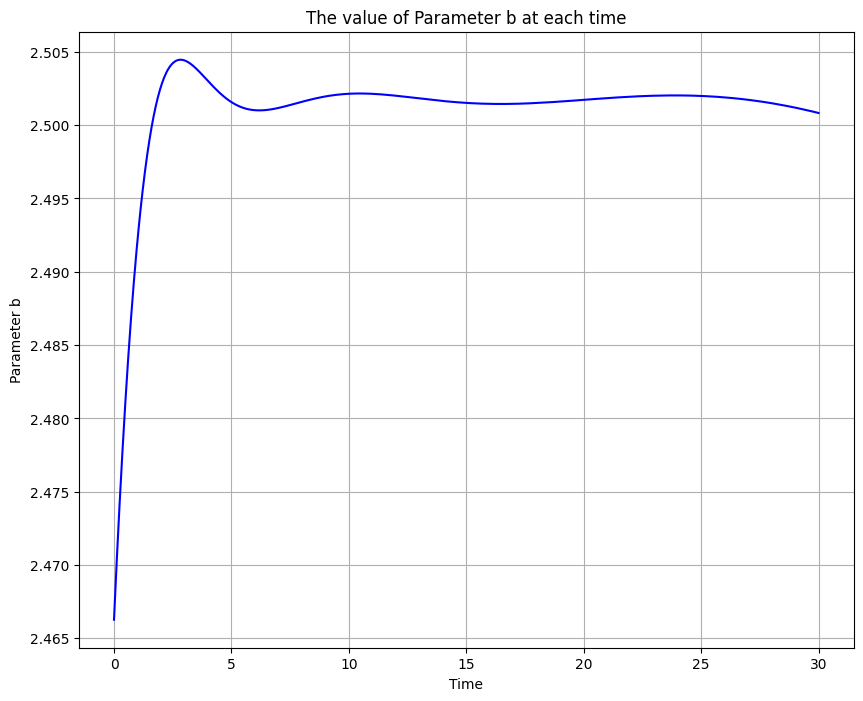

In [13]:
start_range = 0.0
end_range = 30.0

# Find the indices that correspond to the specified range
indices = [i for i, t in enumerate(t_data) if start_range <= t <= end_range]

# Extract the corresponding t_data and aa_pred values
t_data_filtered = [t_data[i] for i in indices]
bb_pred_filtered = [bb_pred[i] for i in indices]

# Plot the filtered data
plt.plot(t_data_filtered, bb_pred_filtered, "b")
plt.xlabel('Time')
plt.ylabel('Parameter b')
plt.grid(True)
plt.title('The value of Parameter b at each time')
plt.show()

In [14]:
import numpy as np

aa = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(aa - i) for i in aa_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_preda = aa_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_preda} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [1.000001] at time step 24, which occurred at [0.72072072].


In [15]:
import numpy as np

bb = 2.5  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(bb - i) for i in bb_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predb = bb_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predb} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [2.500057] at time step 54, which occurred at [1.62162162].


In [16]:
z1_data = np.array(dat1["z1"]).flatten()[:,None]
z2_data = np.array(dat1["z2"]).flatten()[:,None]
t_data = np.array(dat1["# t"]).flatten()[:,None]

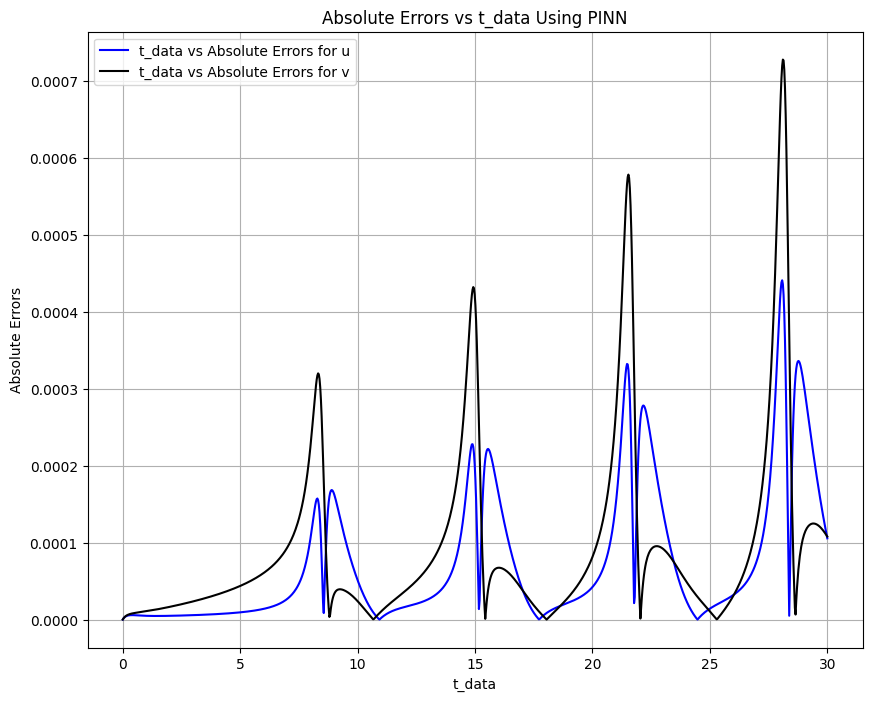

In [17]:
from scipy.integrate import odeint

def system(u, t, k1, k2):
    du1_dt = k1 + u[0]**2*u[1] - (k2 + 1)*u[0]
    du2_dt = k2 * u[0] - u[0]**2 * u[1]
    return [du1_dt, du2_dt]

# Values for k1 and k2 (you need to provide the appropriate values)
k1 = best_preda[0]  # If best_preda is a one-dimensional array
k2 = best_predb[0]  # If best_predb is a one-dimensional array

# Generate more points for a smoother plot
t_fine = np.linspace(t_data.min(), t_data.max(), 1000)

initial_conditions = [1, -1]
u_fine = odeint(system, initial_conditions, t_fine, args=(k1, k2))




t_new = np.array(dat1["# t"]).flatten()
u_pred = odeint(system, initial_conditions, t_new, args=((k1, k2)))

u1_u2 = np.hstack((z1_data, z2_data))


# # plot the absolute errors between the target and the predictions (make sure u1_u2 and t are defined properly)
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_new, np.abs(u1_u2[:, 0] - u_pred[:, 0]), 'b')
plt.plot(t_new, np.abs(u1_u2[:, 1] - u_pred[:, 1]), 'k')
plt.xlabel('t_data')
plt.ylabel("Absolute Errors")
plt.legend(["t_data vs Absolute Errors for u", "t_data vs Absolute Errors for v"])
plt.grid(True)
plt.title("Absolute Errors vs t_data Using PINN")
plt.show()


Loss: 0.2838873


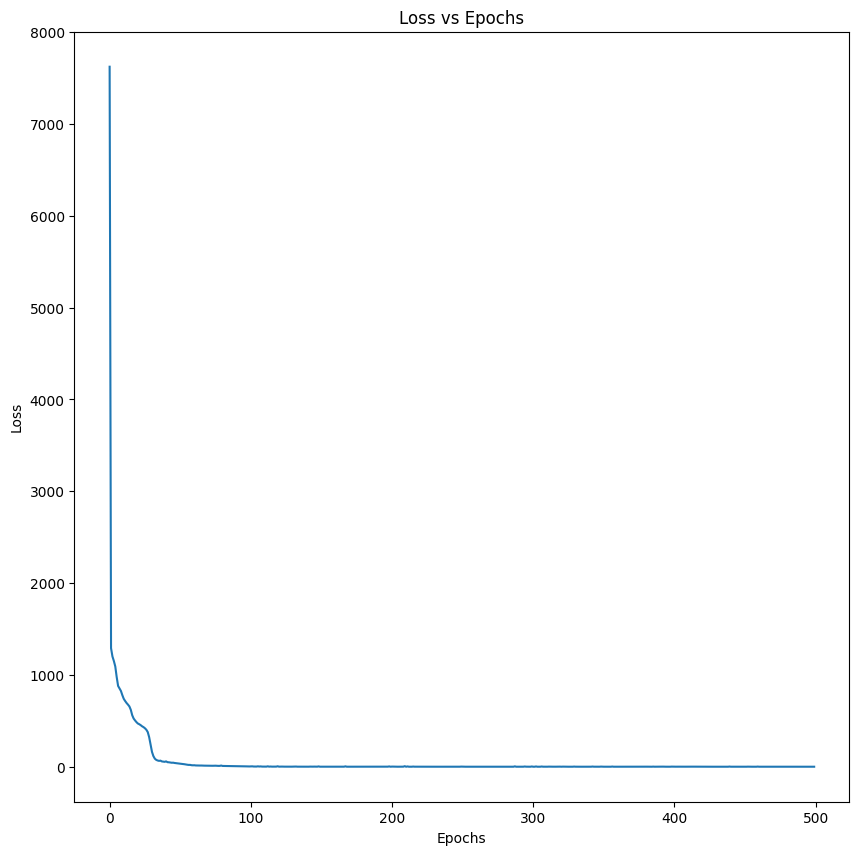

R-squared for u1: 0.999999965329064
R-squared for u2: 0.9999999769975161
Mean absolute error for u1: 7.493169449068693e-05
Mean absolute error for u2: 9.432961202043651e-05
Mean squared error for u1: 1.3703140774721576e-08
Mean squared error for u2: 2.4314706824543235e-08
Root mean squared error for u1: 0.00011706041506299888
Root mean squared error for u2: 0.0001559317377077009
Explained variance score for u1: 0.999999965332021
Explained variance score for u2: 0.9999999806904526


In [18]:
# calculate the loss
loss = model.sess.run(model.loss, {model.t_tf: t_data, model.z1_tf: z1_data, model.z2_tf: z2_data})
print("Loss:", loss)

# plot the loss
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(model.loss_log)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# calculate the R-squared
from sklearn.metrics import r2_score
r2_u1 = r2_score(u1_u2[:, 0], u_pred[:, 0])
r2_u2 = r2_score(u1_u2[:, 1], u_pred[:, 1])
print(f"R-squared for u1: {r2_u1}")
print(f"R-squared for u2: {r2_u2}")

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_u1 = mean_absolute_error(u1_u2[:, 0], u_pred[:, 0])
mae_u2 = mean_absolute_error(u1_u2[:, 1], u_pred[:, 1])
print(f"Mean absolute error for u1: {mae_u1}")
print(f"Mean absolute error for u2: {mae_u2}")

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_u1 = mean_squared_error(u1_u2[:, 0], u_pred[:, 0])
mse_u2 = mean_squared_error(u1_u2[:, 1], u_pred[:, 1])
print(f"Mean squared error for u1: {mse_u1}")
print(f"Mean squared error for u2: {mse_u2}")

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_u1 = mean_squared_error(u1_u2[:, 0], u_pred[:, 0], squared=False)
rmse_u2 = mean_squared_error(u1_u2[:, 1], u_pred[:, 1], squared=False)
print(f"Root mean squared error for u1: {rmse_u1}")
print(f"Root mean squared error for u2: {rmse_u2}")

# calculate the Explained variance score
from sklearn.metrics import explained_variance_score
evs_u1 = explained_variance_score(u1_u2[:, 0], u_pred[:, 0])
evs_u2 = explained_variance_score(u1_u2[:, 1], u_pred[:, 1])
print(f"Explained variance score for u1: {evs_u1}")
print(f"Explained variance score for u2: {evs_u2}")
